In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

In [2]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
img_size = (224, 224)
input_shape = img_size + (3,)
num_classes = 40
batch_size = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='datasets/train',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='datasets/val',
  shuffle=False,
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  shuffle=False,
  directory='datasets/test',
  label_mode="categorical",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


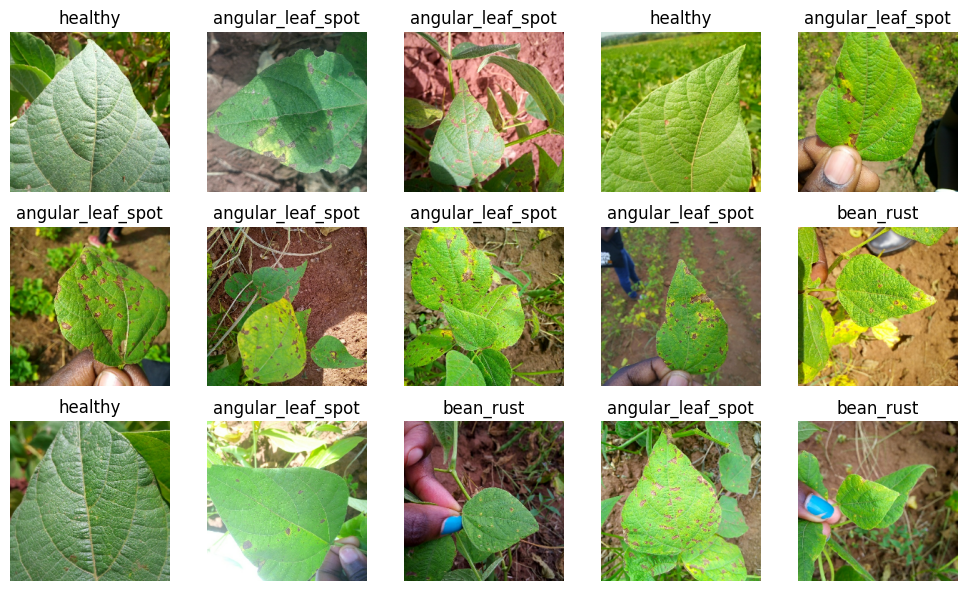

In [5]:
image_batch, label_batch = next(iter(train_ds))
images_to_show = image_batch[:15]
class_names = train_ds.class_names

fig, axes = plt.subplots(3, 5, figsize=(10,6))
axes = axes.flatten()
for img, label, ax in zip(images_to_show, label_batch[:15], axes):
    ax.imshow(img.numpy().astype("uint8"))
    ax.set_title(class_names[label.numpy().argmax()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
y_test_true = np.concatenate([y for x, y in test_ds], axis=0)
y_test_true = np.argmax(y_test_true, axis=-1)

In [6]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Lambda(preprocess_input)(inputs)

resnet_model = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=input_shape,
                        input_tensor=x)

for layer in resnet_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(resnet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [8]:
checkpoint_path = "best_resnet.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

In [9]:
history = model.fit(train_ds, validation_data=val_ds, epochs=25, callbacks=[model_checkpoint, early_stopping])

Epoch 1/25
33/33 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.7427
Epoch 1: val_accuracy improved from -inf to 0.86466, saving model to best_resnet.h5
33/33 [==============================] - 16s 214ms/step - loss: 0.7537 - accuracy: 0.7427 - val_loss: 0.3408 - val_accuracy: 0.8647
Epoch 2/25
32/33 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8730
Epoch 2: val_accuracy improved from 0.86466 to 0.90977, saving model to best_resnet.h5
33/33 [==============================] - 3s 94ms/step - loss: 0.3359 - accuracy: 0.8733 - val_loss: 0.2473 - val_accuracy: 0.9098
Epoch 3/25
32/33 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9258
Epoch 3: val_accuracy improved from 0.90977 to 0.94737, saving model to best_resnet.h5
33/33 [==============================] - 3s 92ms/step - loss: 0.1971 - accuracy: 0.9246 - val_loss: 0.1488 - val_accuracy: 0.9474
Epoch 4/25
32/33 [============================>.] - ETA: 0s - loss: 

In [10]:
final_model = tf.keras.models.load_model("best_resnet.h5")

In [14]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("history_resnet.csv", index=False)

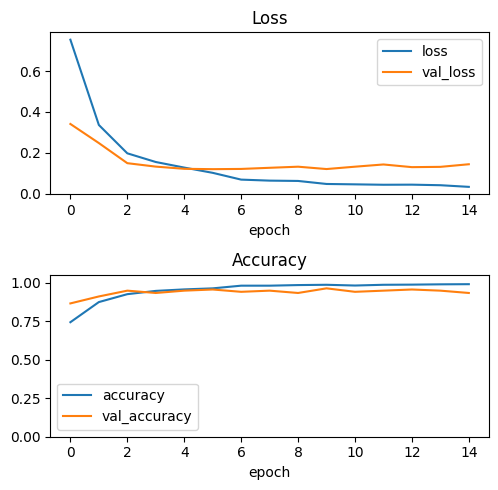

In [15]:
history_df = pd.read_csv("history_resnet.csv")

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(211)
ax1.set_title('Loss')
ax1.plot(history_df['loss'], label='loss')
ax1.plot(history_df['val_loss'], label='val_loss')
ax1.set_xlabel("epoch")
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.set_title('Accuracy')
ax2.plot(history_df['accuracy'], label='accuracy')
ax2.plot(history_df['val_accuracy'], label='val_accuracy')
ax2.set_xlabel("epoch")
ax2.legend()
ax2.set_ylim(0, 1.05) 

plt.tight_layout()
plt.show()

In [16]:
y_test_pred = np.argmax(final_model.predict(test_ds), axis=-1)

4/4 [==============================] - 1s 150ms/step


In [42]:
def format_percent(val):
    return "{:.2f}%".format(val * 100)

In [75]:
report = classification_report(y_test_true, y_test_pred, digits=4, output_dict=True)
class_report = pd.DataFrame(report).transpose()
class_report.iloc[:, :3] = class_report.iloc[:, :3].applymap(lambda x: x * 100)
class_report = class_report.style.format("{:.2f}", subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                              .format("{:.0f}", subset=pd.IndexSlice[:, ['support']])
class_report


,precision,recall,f1-score,support
0,86.96,93.02,89.89,43
1,92.50,86.05,89.16,43
2,100.00,100.00,100.00,42
accuracy,92.97,92.97,92.97,1
macro avg,93.15,93.02,93.01,128
weighted avg,93.10,92.97,92.96,128


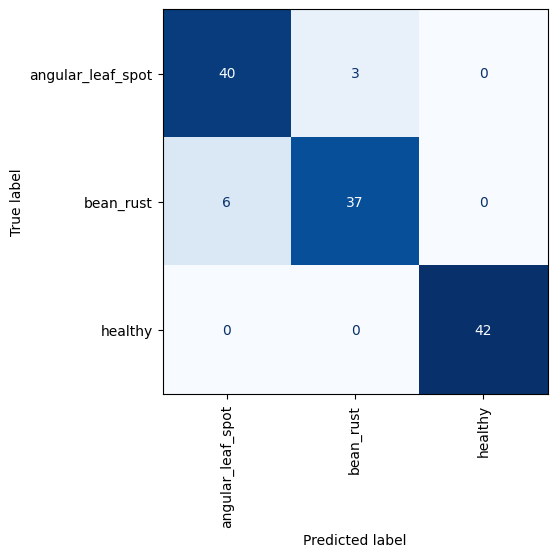

In [23]:
class_names = test_ds.class_names
conf = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(conf, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.show()